# Direct Collapse Black Holes from Axion Decay

This file models DCBHs from axions decay

In [383]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
 %reload_ext autoreload

In [385]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from physics import definitions as phys

import matplotlib
# import integrators
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import quad_vec
# import derivatives
from scipy.misc import derivative
# import interpolator
from scipy.interpolate import interp1d
# import system solver 
from scipy.optimize import fsolve

# import ODE solver
from scipy.integrate import solve_ivp

# import pandas for cosmic variance
import pandas as pd

In [386]:
# Set parameters for plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "arial",
    "font.serif": ["Computer Modern Roman"],
    'font.size': 14
})

In [387]:
print(matplotlib.__version__)

3.9.2


## IGM Mean Intensity

Calculate mean intensity from the IGM. This includes flux attenuation due HI line opacities above $n \geq 3$ Lyman lines.

In [388]:
# Axion Decay rate (s^-1)
def gamma_decay(ma,ga):
    """
    ma - eV
    ga - GeV^(-1)
    output - decay rate s^(-1)
    """
    return (ma*1e-9)**3 * ga**2 *phys.GeV_To_InvSec/(64*phys.pi)

# A list containing Hydrogen n>=3 levels
H_levels = phys.lyman_np_level(np.arange(3,23))


In [389]:
def closest_below(arr, val):
    """
    Function that inputs a list 'arr' and a value 'val' and outputs the largest value smaller than val in the list.
    
    """
    arr = np.asarray(arr)
    val = np.asarray(val)
    
    # Create an output array of the same shape as val to store results
    result = np.full_like(val, np.nan, dtype=float)
    
    for i, v in np.ndenumerate(val):
        # Filter arr to include only elements smaller than the given number
        smaller_elements = arr[arr < v]
        
        # If there are elements smaller than the number, get the maximum element
        if smaller_elements.size > 0:
            result[i] = smaller_elements.max()
    
    return result

In [390]:
closest_below(H_levels,12.5)

array(12.09394871)

In [391]:
print(12<H_levels[0])

True


Define a function for attenuated intensity

In [392]:
# Define a piecewise function for J_IGM using numpy select

def J_IGM_func(z, ma, ga, energy):

    """ 
    energy in eV. 

    Output: Mean IGM intensity [ergs s^(-1) cm^(-1) Hz^(-1) str^(-1)]
    """

    ma = np.asarray(ma)
    energy = np.asarray(energy)
    
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for intensity
    conditions = [
        (ma/2 < H_levels[0]) & (energy<=ma/2),
        (H_levels[0] <= ma/2) & (energy >= closest_val) & (energy <= ma/2),
        (energy >= ma/2)
    ]

    # Define functions for these conditions
    functions=[
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
        0
    ]
    
    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

J_IGM = np.vectorize(J_IGM_func)
    

In [393]:
# Test with scalar inputs
scalar_result = J_IGM(20,25,1e-11,25/2)
print(f"Scalar result: {scalar_result}")

Scalar result: 1.486175599971085e-18


In [394]:
# Test with ma vector results
ma_ray=np.array([20,22,24,25.5])

J_IGM_func(20, ma_ray, 1e-11, 25/2)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50096378e-18])

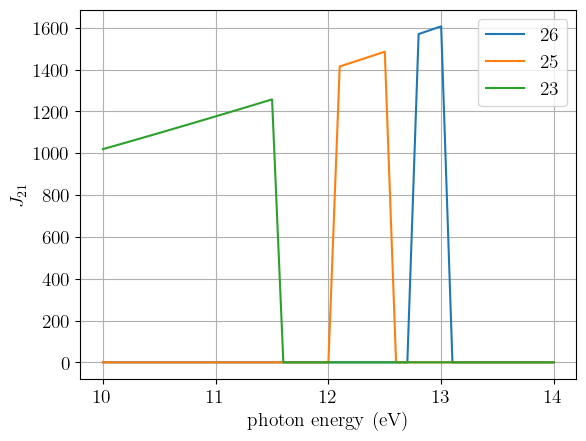

In [395]:
# Plot J IGM for different axion masses
en_space=np.arange(10,14.1,0.1)

plt.plot(en_space, 1e+21*J_IGM(20,26,1e-11, en_space), label=r'26')
plt.plot(en_space, 1e+21*J_IGM(20,25,1e-11, en_space), label=r'25')
plt.plot(en_space, 1e+21*J_IGM(20,23,1e-11, en_space), label=r'23')

plt.xlabel(r'photon energy (eV)')
plt.ylabel(r'$J_{21}$')
plt.legend()
plt.grid()
plt.show()

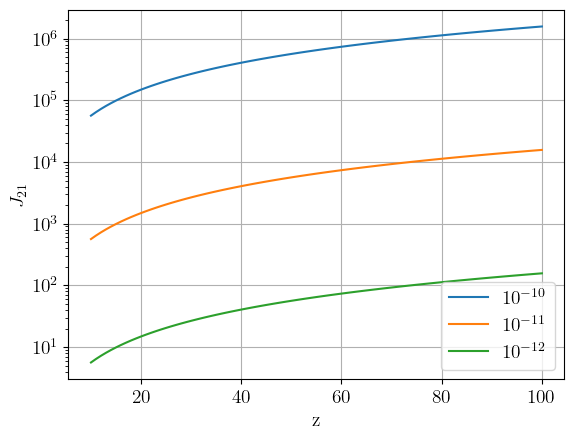

In [396]:
# Plot J_IGM vs z

z_space = np.arange(10,101)

plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-10, 25/2), label=r'$10^{-10}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-11, 25/2), label=r'$10^{-11}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-12, 25/2), label=r'$10^{-12}$')

plt.yscale('log')
plt.xlabel(r'z')
plt.ylabel(r'$J_{21}$')
plt.legend()
plt.grid()
plt.show()

## Define Dissociation Rate Functions

In [397]:
# Define a simple function for Lyman Werner radiation 

def k_LW_func(z, ma, ga):
    """
    Old function to calculate Lyman-Werner dissociation rate. See AxionDecay part for new function. 
    """
    
    ma = np.asanyarray(ma)
    const = 1.39e-12 * 1e+21/2
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for LW dissociation
    conditions=[
        (ma/2>=11.5) & (ma/2<H_levels[0]),
        (ma/2 >=H_levels[0]) & (ma/2 < phys.rydberg_energy),
        (ma/2 <11.5) & (ma/2>= phys.rydberg_energy)
    ]

    # Define dissociation rate values
    functions = [
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - 11.5)/2.1,
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - closest_val)/2.1,
        0
    ]

    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

k_LW = np.vectorize(k_LW_func)
                

In [398]:
k_LW(20,24,1e-11)

array(2.26646025e-10)

In [399]:
# Define a function for photodetachment

"""
Here use quad_vec function in the scipy.integrate library. 
This is suited for integration over functions with varying parameters, but makes the code inefficient.
This is probably the part with highest computation time.
"""

def k_pd_func(z, ma, ga):
    """ 
    Old function to calculate dissocitation photo-detachment rate. See axion decay part to see the new one. 
    """
    ma=np.asarray(ma)
    z=np.asarray(z)
    ga=np.asarray(ga)

    # Define a precursory constant
    const = 4*np.pi/(phys.h_planck * phys.eV_to_ergs)

    # Define a function for integration
    function = lambda en: const*J_IGM(z, ma, ga, en)*phys.sigma_Hm(en)/en

    result, error = quad_vec(function, 0.755, ma/2)

    return result

k_pd = np.vectorize(k_pd_func)

In [400]:
%%timeit
k_pd(20, 25, 1e-11)

225 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [401]:
k_pd(np.array([20]),np.array([25]),1e-11)

array([4.0381108e-10])

In [402]:
J_IGM(20,24.25,1e-11,12.1)

array(1.39402008e-18)

In [403]:
k_pd(np.array([20]),np.array([2,4,6,8,10,25]),1e-11)

array([5.50019513e-11, 1.24836004e-09, 3.06036530e-09, 5.04542250e-09,
       7.07825847e-09, 4.03811080e-10])

Now plot the dissociation rate coefficients

In [404]:
ma_space = 2*np.linspace(11,13.55,5000)
k_LW_20 = k_LW(20, ma_space, 1e-11)
k_LW_40 = k_LW(40, ma_space, 1e-11)
k_LW_60 = k_LW(60, ma_space, 1e-11)

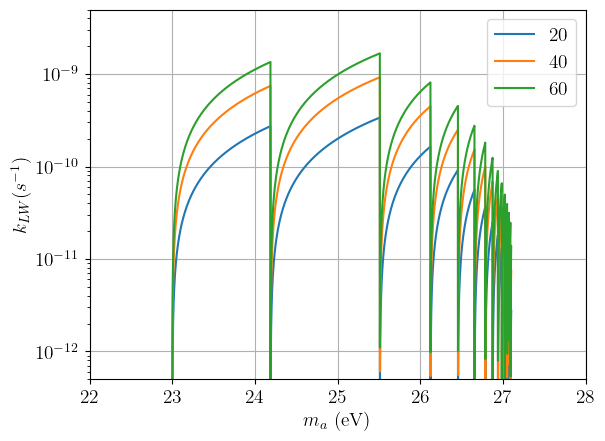

In [405]:
plt.figure()
plt.plot(ma_space, k_LW_20, label=r'20')
plt.plot(ma_space, k_LW_40, label=r'40')
plt.plot(ma_space, k_LW_60, label=r'60')

plt.yscale('log')
plt.xlim(22,28)
plt.ylim(5e-13, 5e-9)
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{LW} (s^{-1})$')
plt.legend()
plt.grid()
plt.show()

In [406]:
list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

In [407]:
%%time
k_pd_20 = k_pd (20, ma_list, 1e-11)

CPU times: user 17.6 s, sys: 67.6 ms, total: 17.7 s
Wall time: 18 s


In [408]:
k_pd_40 = k_pd (40, ma_list, 1e-11)
k_pd_60 = k_pd (60, ma_list, 1e-11)

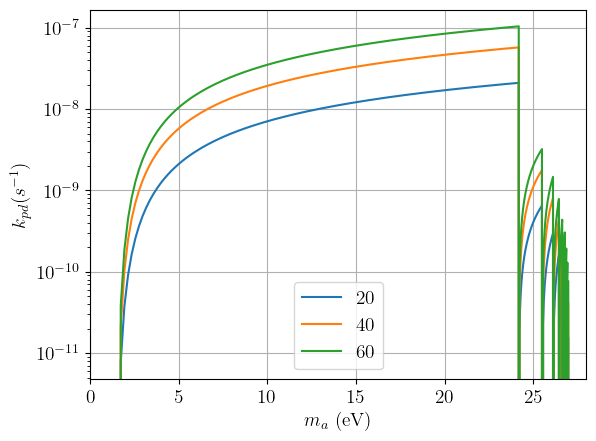

In [409]:
plt.figure()
plt.plot(ma_list,k_pd_20, label=r'20')
plt.plot(ma_list,k_pd_40, label=r'40')
plt.plot(ma_list,k_pd_60, label=r'60')

plt.yscale('log')
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{pd} (s^{-1})$')
plt.xlim(0,28)
plt.grid()
plt.legend()
plt.show()

## Toy Halo Model

In this section of the code, we describe a toy halo model. This includes behavior of dark matter, baryons, and temperature evolution in the standard picture.

We first begin with behavior of dark matter. In this case, we use Mass Accretion Histories, based on Extended Press-Schechter, described in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398). The mass of a halo at any redshift may be written as:
$$
M_H (z) = M_0 (1+z)^{a f(M_0)} \exp{(f(M_0)z)} \ .
$$
Here, $M_0 \equiv M_\text{Halo}(z=0)$ is the only free parameter. The cosmology is encoded in $a$ and $f(M_0)$ via the growth factor $D(z)$, and the variance of the cosmic density field $\sigma(M)$ today (see eq.19-23 in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398)).

Here, the cosmology is accordance to Planck 2018 parameters.


### Dark Matter

In [410]:
# Read the csv file in physics folder
var_path='./physics/Variance2.0.csv'
var_data=pd.read_csv(var_path, header=None, delimiter=',', lineterminator='\n')

In [411]:
pd.DataFrame(var_data)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,1.000000e-09,1.020000e-09,1.050000e-09,1.070000e-09,1.100000e-09,1.120000e-09,1.150000e-09,1.170000e-09,1.200000e-09,1.230000e-09,...,7.940000e+15,8.130000e+15,8.320000e+15,8.510000e+15,8.710000e+15,8.910000e+15,9.120000e+15,9.330000e+15,9.550000e+15,9.770000e+15
1,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,...,2.900000e-01,2.880000e-01,2.860000e-01,2.840000e-01,2.820000e-01,2.800000e-01,2.780000e-01,2.750000e-01,2.730000e-01,2.710000e-01


In [412]:
# Create Data frames for each row - Row 1: mass, and Row 2: variance.

mass_list = var_data.iloc[0]/phys.h
var_list = var_data.iloc[1]

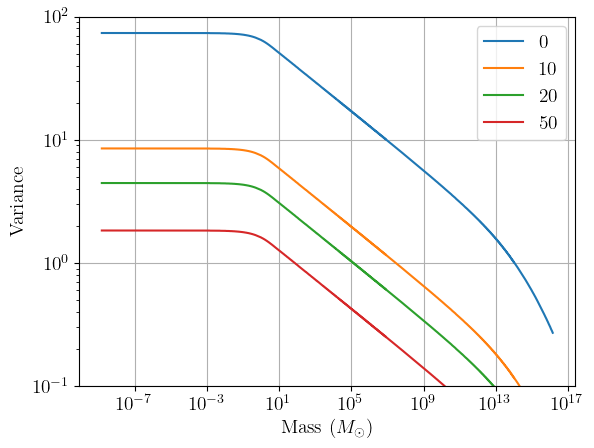

In [413]:
# Plot the variance

plt.figure()
plt.plot(mass_list, var_list, label=r'0')
plt.plot(mass_list, phys.growth_fac(10)*var_list, label=r'10')
plt.plot(mass_list, phys.growth_fac(20)*var_list, label=r'20')
plt.plot(mass_list, phys.growth_fac(50)*var_list, label=r'50')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('Variance')
plt.ylim(0.1,100)
plt.legend()
plt.grid()
plt.show()

# This works

In [414]:
# Create a simple interpolator

cosmic_variance = interp1d(mass_list, var_list, kind='linear')

In [415]:
cosmic_variance(np.array([1e-5,1e+6]))

array([73.5       , 12.91333333])

A good test of the cosmic variance plot is to reproduce $\sigma_8 = 0.811 \pm 0.005$ value from Planck 2018 data.

In [416]:
# Define mass corresponding to 8 h^(-1) Mpc scale of the universe
mass_8 = 4 * np.pi / 3 * 2.8e+11 * phys.Omega_m * phys.h**2 * (8/phys.h)**3

In [417]:
# Cosmic Variance
cosmic_variance(mass_8)

array(0.81420977)

Agrees Well!

In [418]:
"""
Define parameters from Correa 2015.
Growth factor is defined in definitions file.
Since we only need the derivative at z=0 it is simpler to import the value from mathematica
"""
#derivative of growth factor at z=0.
d_growth_0 = -0.512722

afac = d_growth_0*1.686*(2/np.pi)**0.5 + 1

def zfac(m0):
    return -0.0064*np.log10(m0)**2 + 0.0237*np.log10(m0) + 1.8837

def qfac(zf):
    return 4.137*zf**(-0.9476)

def ffac(m0):
    n1 = zfac(m0)
    n2 = qfac(n1)

    val1 = cosmic_variance(m0/n2)
    val2 = cosmic_variance(m0)

    return (val1**2 - val2**2)**(-1/2)


In [419]:
# With the parameters defined now define mass accretion histories

def MAH(M0 , z):
    return M0 * (1+z)**(afac*ffac(M0)) * np.exp(-ffac(M0)*z)

### Baryons

The density evolution of baryons in halos is goverened by Jeans/filtering mass criteria if there are no extra cooling or heating terms. The filtering mass can be written as (with no streaming velocity) [Hegde 2023](https://inspirehep.net/literature/2650114)
$$
 M_F = 1.66 \times 10^4 \left(\frac{1 + z}{21} \right)^{0.85} \ M_\odot
$$

In [420]:
def filter_mass(z):
    return 1.66e+4 * ((1+z)/21)**(0.85)

In [421]:
filter_mass(21)

17269.54781676384

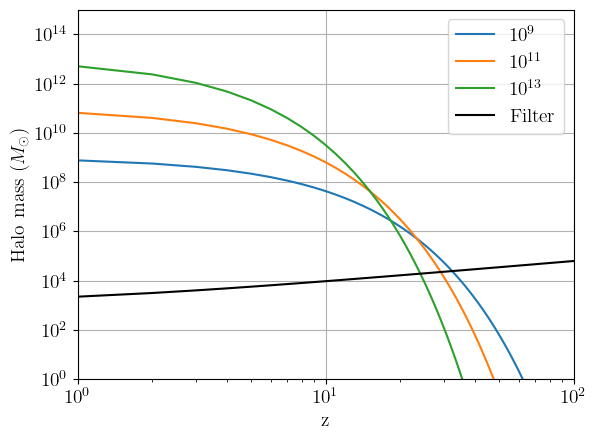

In [422]:
# Plot histories for a few final halo masses: 1e+9, 1e+11.5, 1e+14
z_list=np.arange(0,101)

plt.figure()
plt.plot(z_list, MAH(1e+9,z_list), label=r'$10^{9}$')
plt.plot(z_list, MAH(1e+11,z_list), label=r'$10^{11}$')
plt.plot(z_list, MAH(1e+13,z_list), label=r'$10^{13}$')
plt.plot(z_list, filter_mass(z_list), label='Filter', color='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'Halo mass ($M_\odot$)')
plt.xlim(1,100)
plt.ylim(1,1e+15)
plt.grid()
plt.legend()
plt.show()

As one can see from the graph above, smaller halos that collapse earlier also cross the filtering threshold before higher mass halos. 

Now we define virialization redshift i.e. $M_\textnormal{Halo} (M_0, z_\textnormal{vir}) = M_F (z_\textnormal{vir})$

In [423]:
def zvir(M0):
    return fsolve(lambda z: MAH(M0, z) - filter_mass(z), 30)
 

In [424]:
MAH(1e+8,31)

np.float64(34703.86313642498)

In [425]:
23772/(1e+6)

0.023772

In [426]:
zvir(1e+9)

array([32.39539417])

### Density evolution

For density evolution, I am using the accurate model based on simulations [Visbal 2014](https://academic.oup.com/mnrasl/article/442/1/L100/955995). Unfortunately, there isn't a smooth way to transition from IGM density to the collapsed density, so I've patched the two pieces together with a sigmoid function with a variable parameter. The results should not be too sensitive to this choice, and so still appropriate for out analysis. 


In [427]:
# Define a base halo model. 
def nH_Halo (k , m0, z):

    """
    k - parameter to sigmoid function
    m0 - final halo mass 

    returns H number density [cm^3 s^(-1)]
    """

    m0 = np.asarray(m0)
    z = np.asarray(z)

    # Calculate redshift of virialization
    z_vir = zvir(m0)

    # Define sigmoid of x
    sigmoid_x = 1 / (1 + np.exp(- k * (z - z_vir) ))

    # z > zvir
    val_1 = phys.nH0*(1+z)**3

    # z <= zvir
    val_2 = 1.2 * MAH(1e+8,z_vir)/(1e+6) * (( 1+z_vir ) / 10)**(3/2)

    return (sigmoid_x)*val_1 + (1 - sigmoid_x)*val_2


In [428]:
def nH_Halo_crude(zvir, z):

    # Convert arguments to array
    zvir = np.asarray(zvir)
    z = np.asarray(z)
    
    # Define A
    A = (1+zvir)/(1+z)
    # Define conditions for pre and post collapse
    conditions = [
        (z>zvir),
        (z<=zvir)
    ]

    # Define values to return
    funcs=[
        phys.nH0*(1+z)**3 * np.exp((1.9*A) / (1 - 0.75*A**2)),
        ##1.2 * MAH(1e+8,zvir)/(1e+6) * ((1+zvir) / 10)**(3/2)
        phys.nH0*(1+zvir)**3 * np.exp(1.9 / (1 - 0.75))
    ]

    return np.select(conditions, funcs, default=0)

In [429]:
# Now plot halo number density for varying sigmoid parameter
z_list=np.arange(0,101)
zvir_list=np.array([zvir(1e+8),zvir(1e+9),zvir(1e+10), zvir(1e+11), zvir(1e+12)])

In [430]:
zvir_list[0]

array([32.30965386])

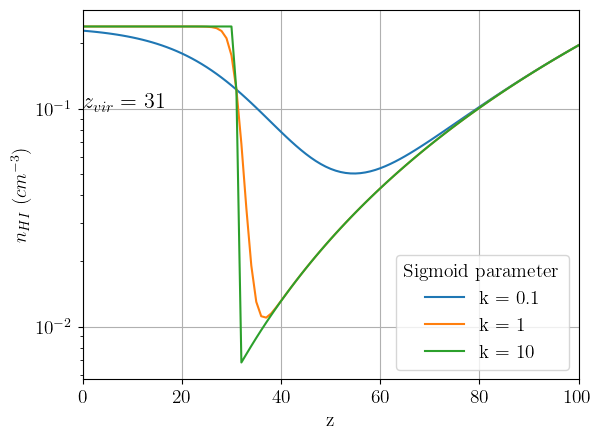

In [431]:
# Plot nH(z) for a few parameters of sigmoid. 
plt.figure()
plt.plot(z_list, nH_Halo(0.1, 1e+10, z_list), label = r'k = 0.1')
plt.plot(z_list, nH_Halo(1, 1e+10, z_list), label = r'k = 1')
plt.plot(z_list, nH_Halo(10, 1e+10, z_list),  label = r'k = 10')

plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'$n_{HI}$ ($cm^{-3}$)')
plt.text(0, 1e-1, r'$z_{vir} = 31$', fontsize = 16)
plt.legend(title = 'Sigmoid parameter')
plt.xlim(0,100)
plt.show()

In [432]:
zvir_list

array([[32.30965386],
       [32.39539417],
       [30.99711393],
       [29.12567409],
       [26.77405637]])

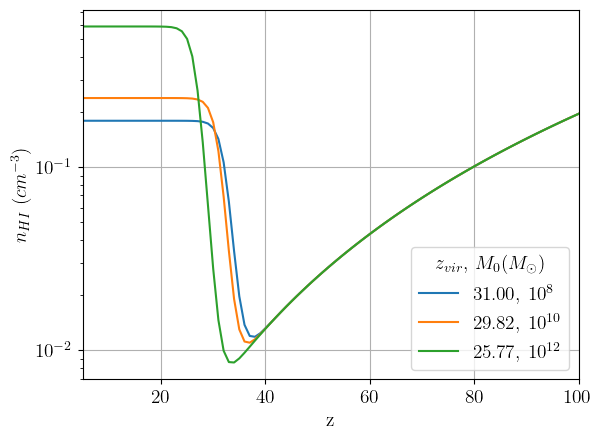

In [433]:
# Plot nH(z) for k = 1, and different zvir 
plt.figure()
plt.plot(z_list, nH_Halo(1, 1e+8, z_list), label = r'31.00, $10^8$')
plt.plot(z_list, nH_Halo(1, 1e+10, z_list), label = r'29.82, $10^{10}$')
plt.plot(z_list, nH_Halo(1,1e+12, z_list),  label = r'25.77, $10^{12}$')

plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'$n_{HI}$ ($cm^{-3}$)')
plt.legend(title = r'$z_{vir}$, $M_0 (M_\odot)$')
plt.xlim(5,1e+2)
plt.show()

In [434]:
MAH(1e+8, 10)

np.float64(8509501.268948862)

### Temperature evolution

Since, there are no processes changing temperature of baryonic gas, except changes in H2 chemistry, we can model the temperature in a similar way to number density evolution i.e.

$$ 
 T_{halo} (z) \approx T_{IGM} \ , \ \text{for } z \gtrsim z_{vir}
$$
and
$$ 
T_{halo} (z) \approx T_{vir} \ , \text{for } z \lesssim z_{vir} \ .
$$

In [435]:
# Define a base temperature function 

def T_halo (k, m0, z): 

    """
    k - parameter to sigmoid function
    m0 - final halo mass
    """

    z = np.asarray(z)

    # Define sigmoid of x
    sigmoid_x = 1 / (1 + np.exp(- k * (z - zvir(m0))) )
    
    # z >> zvir
    temp_1 = phys.T_IGM(z)

    # z <= zvir 
    temp_2 = phys.Tvir(z, MAH(m0, z))

    return (sigmoid_x)*temp_1 + (1-sigmoid_x)*temp_2

In [436]:
T_halo(1, 1e+9, 10)

array([10347.70570718])

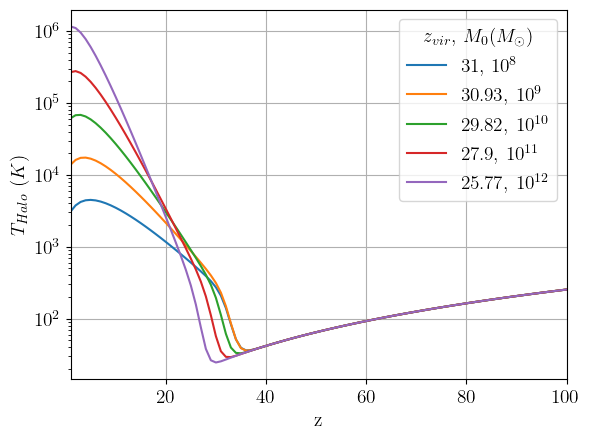

In [437]:
# Plot T_halo(z) for k = 1, and different zvir 
plt.figure()

plt.plot(z_list, T_halo(1, 1e+8, z_list), label = r'31, $10^{8}$')
plt.plot(z_list, T_halo(1, 1e+9, z_list), label = r'30.93, $10^{9}$')
plt.plot(z_list, T_halo(1, 1e+10, z_list), label = r'29.82, $10^{10}$')
plt.plot(z_list, T_halo(1, 1e+11, z_list), label = r'27.9, $10^{11}$')
plt.plot(z_list, T_halo(1, 1e+12, z_list), label = r'25.77, $10^{12}$')

plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'$T_{Halo}$ ($K$)')
plt.xlim(1,1e+2)

plt.legend(title = r'$z_{vir}$, $M_0 (M_\odot)$')
plt.show()

#### Comparing Time Scales

There is some modeling confusion on what the critical $H_2$ fraction is for DCBH formation. To resolve this issue we should compare the relevant time scales in our system: free fall - Hubble time scale (a time scale threshold needed for effective cooling) vs $H_2$ cooling time scale. 

The free fall time scale in the cores of the halo is given as: 
$$ 
\begin{align}
t_{ff} & = \left( \frac{3 \pi}{32 G \bar{\rho}_{core}}\right)^{1/2} \\
    & = 1.5 \times 10^7 \left(\frac{1+z_{vir}}{10}\right)^{-3/2} \ \text{yrs} \ .
\end{align}
$$

On the other hand, $H_2$ cooling time scale is given as 

$$ 
\begin{align}
    t_{cool} = \left( \frac{3 n_{core} k_B T_{vir}}{2 \Lambda (n_{core}, T_{vir})} \right) \ ,
\end{align}
$$

where $\Lambda (n,T)$ is the cooling rate in ergs cm$^{-3}$ s$^{-1}$. 

**Important!**
$T_{vir}$ is the halo temperature at any point along its mass accretion history. Since the virial temperature increases with time, the $H_2$ cooling efficiency changes with time as well, $\Lambda_{H_2} \propto T^{3.4}$. But the density in the core is completely determined by the collapse redshift, $z_{vir}$, and is kept constant afterwards. 

Therefore, the model predicts that the core density stays constant with time after collapse, owing to lack of coolant. But it still experiences heating from mass accretion by the halo. This is ultimately primary mechanism for triggering atomic cooling halos. 


In [497]:
# Define a function for free fall time scale 

def t_ff (zvir): 

    """ returns free fall time scale for a halo virializing/collapsing at zvir"""
    return 1.5e+7 * ((1+zvir)/10)**(-3/2) * phys.yrs_to_sec

In [498]:
print(f'The free fall time scale for z_vir = {zvir(1e+9)[0]:.4} is t_ff = {t_ff (33) /phys.yrs_to_sec:.4} yrs')

The free fall time scale for z_vir = 32.4 is t_ff = 2.393e+06 yrs


In [499]:
# Define a function to calculate H2 cooling time scale 

def t_H2(xH2, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H2(xH2, ncore, temp)

In [441]:
print(f'The cooling time scale t_cool = {t_H2(1e-3, 0.1, 3e+3) / phys.yrs_to_sec:.4} yrs')

The cooling time scale t_cool = 8.699e+06 yrs


In [442]:
crit_H2(1e-3, 20)

array([4.252457e-06])

### Simple test against Mathematica code

This next piece is to simply check against mathematica answers. 

In [443]:
# Define parameters for the base model
m0_base = 1e+11
zvir_base = 28
xe_base = np.array([5e-4]) # Free electron fraction at z~ 100 after recombination

"""
Define differential equation for electron recombination
"""

def dxe_dz_test (z, xe):
    val = (( phys.case_B(3000) * nH_Halo_crude(zvir_base, z) * xe**2) / 
           ((1+z) * phys.Hubble(z)))
    return val
    # T_halo(1, m0_base, z)
# Define redshift range of interest
z_span = (101, 0)
z_eval=np.arange(101,0,-0.1)

# Solve the ODE 

solution_test = solve_ivp(dxe_dz_test, z_span, xe_base, t_eval= z_eval, rtol=1e-10, atol=1e-10 )

<function matplotlib.pyplot.show(close=None, block=None)>

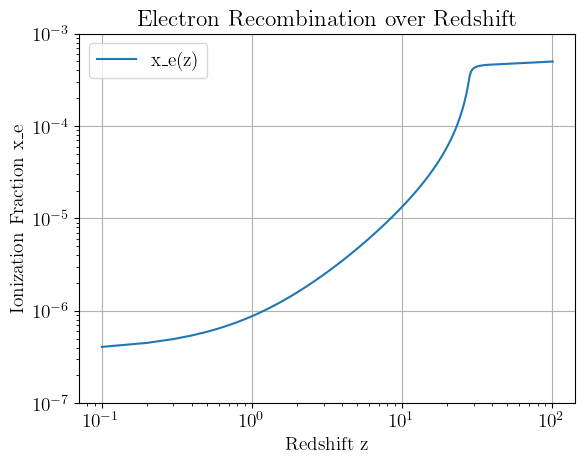

In [444]:
# Plot the results
plt.plot(solution_test.t, solution_test.y[0], label='x_e(z)')
plt.xlabel('Redshift z')
plt.ylabel('Ionization Fraction x_e')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-7,1e-3)
plt.grid(True)
plt.show

This part sucessfully reproduces mathematica result. 

## Base History

With the halo internal properties defined, we can now model a baseline model for $x_e$ history. To do this let's take $M_0 = 10^{10} \, M_\odot$ and $z_{vir} = 29.82$. Also we can take the free electron fraction at the end of recombination as $2 \times 10^{-4}$.

### Base x_e

In [445]:
# Define parameters for the base model
m0_base = 1e+9
zvir_base = zvir(1e+9)
xe_initial = np.array([2e-4]) # Free electron fraction at z~ 100 after recombination


In [446]:

"""
Define differential equation for electron recombination
"""

def dxe_dz_base (z, xe):
    val = (( phys.case_B(T_halo(1, m0_base, z)) * nH_Halo(1, m0_base, z) * xe**2) / 
           ((1+z) * phys.Hubble(z)))
    return val
    # T_halo(1, m0_base, z)
# Define redshift range of interest
z_span = (120, 0)
z_eval=np.arange(120,0,-0.1)

# Solve the ODE 
solution_base_xe = solve_ivp(dxe_dz_base, z_span, xe_initial, t_eval= z_eval, rtol=1e-10, atol=1e-10 )

<function matplotlib.pyplot.show(close=None, block=None)>

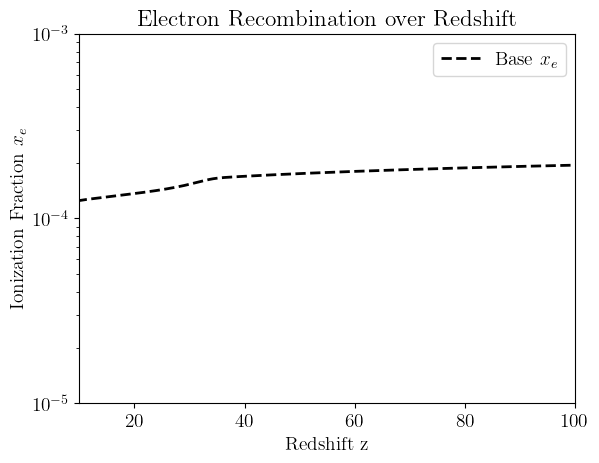

In [447]:
# Plot the results
plt.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'Base $x_e$', 
         linewidth=2, color='black', linestyle='dashed')
plt.xlabel('Redshift z')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')

plt.legend()
plt.ylim(1e-5,1e-3)
plt.xlim(10,100)
plt.show

In [448]:
# Create an interpolating function to store 
xe_base = interp1d(solution_base_xe.t, solution_base_xe.y[0])

### Base H2

In [500]:
"""
Define a function to calculate critical H2 fraction as a function of redshift. 
The following function finds xH2_crit from the two cooling time scales define earlier, 
and is modeled on the base halo model we have defined earlier. 

"""

def crit_H2(z, si):

    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
    For Hubble time/age of the universe we use si = 36.3. 
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, nH_Halo(1, 1e+9, z), T_halo(1, 1e+9, z)) - si * t_ff(zvir(1e+9))

    # Get the critical redshift zvir_value
    zvir_value = zvir(1e+9)
    
    # Create a mask for valid z values
    mask = z < zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-5, args=(z[i], si))[0]  # Extract the root from fsolve

    return fac


In [501]:
crit_H2(np.array([10,20,30]),36.3)

array([2.83901743e-06, 1.22395790e-04, 1.34775648e-02])

In [502]:
""" 
This entire cell has old critical value calculations I was using. 

"""


# Define critical H2 fraction to cool within Hubble time 
def crit_H2_Furlanetto(z, Tm):

    # Convert scalar inputs to arrays
    z = np.atleast_1d(z)
    Tm = np.atleast_1d(Tm)
    
    T3=Tm/(1e+3)
    fac = (
        1.6e-4 * ((1+z)/ 20)**(-3/2) * 
        (1 + 10*T3**(7/2) / (60 + T3**4))**(-1) * 
        np.exp(512 / Tm)
    )

    zvir_value = zvir(m0_base)
    mask = (z < zvir_value)
    result = np.zeros_like(fac)  # Initialize the result array with zeros
    
    result[mask] = fac[mask]  # Apply the mask to assign fac to the result where the mask is True
    result[~mask] = np.nan
    
    # If the input was scalar, return scalar
    if result.size == 1:
        return result[0]
    return result

# Similarly define critical fraction according to Nebrin 2023
def crit_H2_Nebrin(z, si):
    """ 
    Here si is simply a multiplicative factor to free fall timescale. 
    si = 1 => Free fall cooling time scale or the shortest time scale. Requires highest H2 fraction. 
    si = 6. Threshold taken by Nebrin which reproduces the cooling time scale as seen in simulations. 
    It also signfies time scale when 50% of the halos can be expected to cool.
    si = 36.3 => The cooling threshold is set by Hubble time scale,
    also the minimum H2 required for gas to cool effectively at any redshift.
    """
    
    # Convert scalar inputs to arrays
    z = np.atleast_1d(z)

    M6 =  MAH(m0_base, z) / (1e+6)
    print(M6)

    fac = 1.4e-3 * M6**(-2.6) * ( (1+z) / 10)**(-2.4) / si
    
    zvir_value = zvir(m0_base)
    mask = (z < zvir_value)
    result = np.zeros_like(fac)  # Initialize the result array with zeros

    result[mask] = fac[mask]  # Apply the mask to assign fac to the result where the mask is True
    result[~mask] = np.nan
    
    # If the input was scalar, return scalar
    if result.size == 1:
        return result[0]
    return result

In [503]:
## First define a H^- dissociation rate due to CMB photons. This suppresses H2 formation before structure formation.

def k_pd_CMB(z): 
    val = ( 
        4 * (2*np.pi)**(3/2) *
        ( phys.me_eV * phys.kB * phys.T_CMB(z) )**(3/2) / 
        (phys.h_planck * phys.cs)**3 * 
        np.exp(-0.754 / phys.kB / phys.T_CMB(z)) * 
        phys.C_Hminus(T_halo(1, m0_base, z))
    )

    return val

In [504]:
k_pd_CMB(67)

array([9.07381777e-18])

In [505]:
# Define base H2 history function for H2 production
def dH2_dz_base (z, xH2): 
    val_1 = - phys.C_Hminus(T_halo(1, m0_base, z)) * xe_base(z) * (1-xe_base(z)) * nH_Halo(1, m0_base, z) / (1+z) / phys.Hubble(z) 

    val_2 = (1 + k_pd_CMB(z) / (phys.C_H2(T_halo(1, m0_base, z)) * (1-xe_base(z)) * nH_Halo(1, m0_base, z)) )**(-1)
    
    return val_1*val_2

In [506]:
dH2_dz_base (50, 1e-8)

array([-1.35243083e-08])

In [507]:
# Define redshift range of interest
z_span = (119.9, 0.2)
z_eval=np.arange(119.9,0.2,-0.1)

# Solve the ODE 
"""
Here I've used the H2 abundance in the IGM as 10^(-8) as initial condition
"""
solution_base_xH2 = solve_ivp(dH2_dz_base, z_span, np.array([1e-8]), t_eval= z_eval, rtol=1e-10, atol=1e-10 )

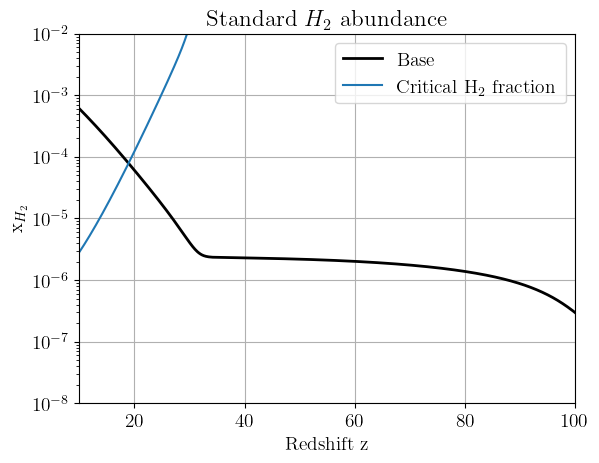

In [508]:
# Plot the results
plt.plot(solution_base_xH2.t, solution_base_xH2.y[0], label='Base', linewidth=2, color='black')
plt.plot(z_eval, crit_H2(z_eval, 36.3), label = r'Critical H$_2$ fraction' )

plt.xlabel('Redshift z')
plt.ylabel(r'x$_{H_2}$')
plt.title('Standard $H_2$ abundance')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlim(10,100)
plt.ylim(1e-8,1e-2)
plt.show()

## Axion decay

The photo-detachment integrals are extremely slow for computational processes. In this case, redefine the photo-detachment function for easier computation. The easiest way to do this is to compute the energy integral separately, and simply multiply by some function of other parameters. 

In [509]:
# Assuming low_limit function and H_levels are defined elsewhere
def low_limit(ma):
    if ma / 2 < H_levels[0] and ma / 2 >= 0.755:
        return 0.755
    elif ma / 2 >= H_levels[0]:
        return closest_below(H_levels, ma / 2)

# Define the cross-section integral
def cs_int_func(ma):
    eth = 0.755
    ma = np.asarray(ma, dtype='float')


    def integrand(en):
        return (en - eth)**(3 / 2) / en**(5 / 2)

    results = []

    
    if np.isscalar(ma) == True: 
        e_max = ma/2
        e_min = low_limit(ma)
        result, error = quad(integrand, e_min, e_max)
        return result
    else:
        for m in ma:
            e_max = m / 2
            e_min = low_limit(m)
            result, error = quad(integrand, e_min, e_max)
            results.append(result)

    return np.array(results)



In [510]:
7.982e+5 *phys.h_planck**(3/2)* cs_int_func(np.array([0.755*5]))

array([4.33932147e-17])

In [511]:
cs_int_func(np.array([2]))

array([0.01446079])

In [512]:
# Redefine k_pd 

def k_pd (z, ma, ga):

    ma = np.asarray(ma, dtype='float')  # Convert ma to a numpy array

    # Ensure ma is 1-dimensional
    if ma.ndim == 0:  # If ma is a scalar (0-d array), convert it to 1-d
        ma = np.array([ma])

    # Define a factor to impose broadcasting if statments on axion mass and calculate axion mass dependent quantities
    fac = np.zeros_like(ma) 

    # Use masks 
    mask_zero = (ma/2 < 0.755) | (ma/2 >= phys.rydberg_energy)
    fac[mask_zero] = 0
    
    mask_one = (ma/2 >= 0.755) & (ma/2 < phys.rydberg_energy) 
    fac[mask_one] = cs_int_func(ma[mask_one]) 

    # Define a prefactor constant 
    const = (7.982e+5 * phys.cs * phys.h_planck**(3/2) * 2**(5/2) * phys.RhoCrit * phys.Omega_c * (1 + z) ** 3 *gamma_decay(ma,ga)
             / phys.Hubble(z) / ma**(5/2))

    return const*fac
    

In [513]:
k_pd(20,np.array([1,2,25,27,29]), 1e-11)

array([0.00000000e+00, 5.53765862e-11, 4.06561559e-10, 6.45612029e-12,
       0.00000000e+00])

In [514]:
k_pd(np.array([20,40,60]), 25,1e-11)

array([4.06561559e-10, 1.10921977e-09, 2.01298888e-09])

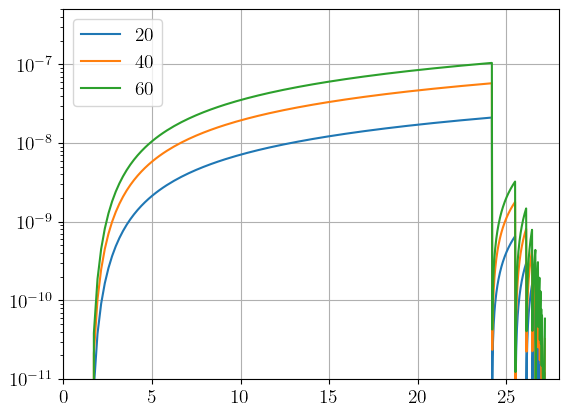

In [515]:
# print new k_pd 

list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

plt.figure()

plt.plot(ma_list, k_pd(20, ma_list, 1e-11), label='20')
plt.plot(ma_list, k_pd(40, ma_list, 1e-11), label='40')
plt.plot(ma_list, k_pd(60, ma_list, 1e-11), label='60')

plt.ylim(1e-11, 5e-7) 
plt.xlim(0,28)
plt.yscale('log')
plt.legend()
plt.grid()

Note this produces the earlier version and the mathematica result. 

In [516]:

# Define Doppler broadening velocity 
def doppler(Tm): 
    return (phys.kB *Tm / phys.mp_eV)**(1/2) * phys.cs

# Define the power in the shielding factor denominator, call eta 
def eta (Tm, n): 
    A1 = 0.8711*np.log10(Tm) - 1.928 
    A2 = -0.9639*np.log10(Tm) + 3.892
    val = A1 * np.exp(-0.2856*np.log10(n)) + A2 
    return val 

# Define a function to calculate shielding factor 
def f_sh(Tm, ncore, rcore, xH2): 
    """ 
    Parameters: 
    Tm - matter temperature (K) 
    ncore - density at the core (cm^-3)
    rcore - radius of the core in pc 
    xH2 - H2 fraction
    """
    xH2 = np.asarray(xH2)
    
    # Define H2 column density / 5e+14 cm^2
    NH2 = 0.926 * ncore * rcore *phys.pc_to_cm * xH2 / (5e+14)
    b5 = doppler(Tm) / (1e+5)
    
    val_1 = 0.965 / ((1 + NH2/b5)**(eta(Tm,ncore)))
    val_2 = 0.035 / ((1 + NH2)**(0.5))

    return val_1 + val_2 

In [517]:
f_sh(3000, 0.1, 10, 1e-5)

np.float64(0.9771965564960908)

In [518]:
eta(10000,0.1)

np.float64(2.1072837781506126)

In [519]:
# Redefine k_LW

def k_LW(z, ma, ga): 

    ma = np.asarray(ma, dtype=float)  # Ensure ma is always a float array
    energy = ma/2

    frac = np.zeros_like(ma)

    # Try using masks 
    mask_zero = (ma/2 < 11.5) | (ma/2 >= phys.rydberg_energy)
    frac[mask_zero] = 0

    mask_one = (ma / 2 >= 11.5) & (ma/2 < H_levels[0])
    frac[mask_one] = ma[mask_one]/2 - 11.5

    mask_two = (ma/2 >= H_levels[0]) & (ma/2 < phys.rydberg_energy)
    frac[mask_two] = ma[mask_two]/2 - closest_below(H_levels, ma[mask_two]/2)

    J_igm = 2 * phys.cs * phys.h_planck * phys.eV_to_ergs / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5

    return 1.39e+9* frac *J_igm / 2
    


In [520]:
k_LW(np.array([20,40,60]), 25, 1e-11)

array([4.19407145e-10, 1.14426632e-09, 2.07659062e-09])

In [521]:
k_LW (20, np.array([22,23,24,25,26,27,28,29,30]), 1e-11)

array([0.00000000e+00, 0.00000000e+00, 4.75956653e-10, 4.19407145e-10,
       2.73332163e-10, 8.13389810e-12, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [522]:
ma_space = 2*np.linspace(11.5,13.58,5000)

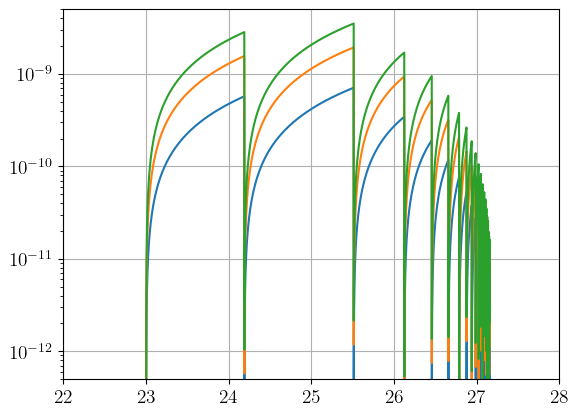

In [523]:
# Plot LW dissociation rates again 
plt.figure()

plt.plot(ma_space, k_LW(20, ma_space, 1e-11), label='z=20')
plt.plot(ma_space, k_LW(40, ma_space, 1e-11), label='z=40')
plt.plot(ma_space, k_LW(60, ma_space, 1e-11), label='z=60')

plt.yscale('log')
plt.xlim(22,28)
plt.ylim(5e-13, 5e-9)
plt.grid()
plt.show()

### H$_2$ histories with axion decay

In [524]:
# Define differential equation for x_H2

def dxH2_dz (z, xH2, ma, ga): 

    ma = np.asarray(ma)
    ga = np.asarray(ga)

    # base formation term
    form = phys.C_Hminus(T_halo(1, m0_base, z)) * xe_base(z) * nH_Halo(1, m0_base, z)
    
    # photodetachment term 
    pd = 1 + k_pd(z, ma, ga) / (phys.C_H2(T_halo(1, m0_base, z)) * nH_Halo(1, m0_base, z))

    # LW dissociation term 
    lw = xH2*k_LW(z, ma, ga) * f_sh( T_halo(1, m0_base, z), nH_Halo(1, m0_base, z), 0.1*phys.Rvir(z, MAH(m0_base, z)), xH2)

    return (-1 / phys.Hubble(z) / (1+z)) * (form / pd  - lw)
    

In [525]:
dxH2_dz (20, 1e-4, 25, 1e-13)

array([0.00085837])

In [526]:
dxH2_dz(np.array([1,5,10,15,20, 25, 30, 35, 40]), 1 , 25,1e-11)

array([ 40.16847405,  35.96323701,  35.15589979,  38.45938225,
        44.34001735,  52.69986604,  66.58785795, 242.94839132,
       428.57744018])

In [527]:
dxH2_dz(20, 1 ,25, np.array([1e-10, 1e-11, 1e-12]))

array([4.43400226e+03, 4.43400173e+01, 4.43385447e-01])

In [528]:
# Try solving the differential equation 

# initial condition
xH20 = np.array([1e-7])

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_1 = 25
ga_1 = 1e-13

In [529]:
%%time
solution_xH2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(ma_1, ga_1), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-11 )

CPU times: user 2.36 s, sys: 11.8 ms, total: 2.37 s
Wall time: 2.37 s


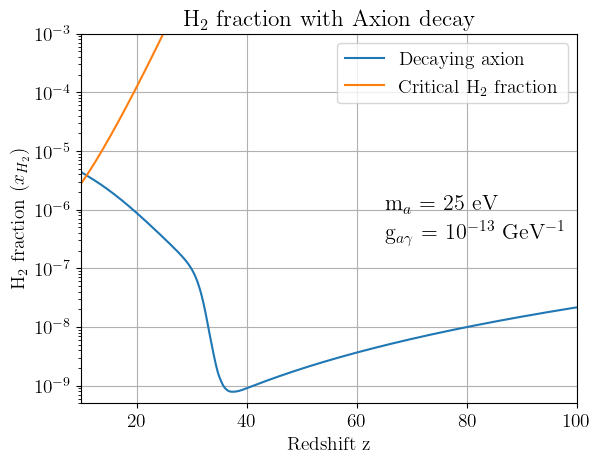

In [530]:
# Plot the results
plt.figure()

plt.plot(solution_xH2.t, solution_xH2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, 36.3), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65,1e-6, r'm$_a$ = 25 eV', fontsize=16)
plt.text(65,3e-7, r'g$_{a \gamma}$ = 10$^{-13}$ GeV$^{-1}$', fontsize=16)

plt.legend()
plt.xlim(10,100)
plt.ylim(5e-10,1e-3)
plt.grid()
plt.show()

In [531]:
# Try a solution with just photodetachment 

ma_2 = 5
ga_2 = 1e-11

In [532]:
%%time
solution_xH2_2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(ma_2, ga_2), 
                         t_eval= z_eval,  
                         rtol=1e-4, atol=1e-11, 
                          vectorized=True)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_54553/2742329004.py:28: RuntimeWarning: invalid value encountered in sqrt
  val_2 = 0.035 / ((1 + NH2)**(0.5))
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_54553/2742329004.py:27: RuntimeWarning: invalid value encountered in power
  val_1 = 0.965 / ((1 + NH2/b5)**(eta(Tm,ncore)))


CPU times: user 603 ms, sys: 20 ms, total: 623 ms
Wall time: 627 ms


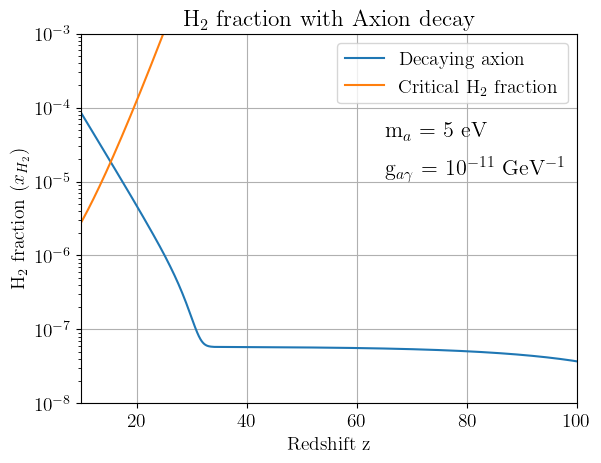

In [491]:
# Plot the results
plt.figure()

plt.plot(solution_xH2_2.t, solution_xH2_2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, 36.3), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65, 4e-5, r'm$_a$ = 5 eV', fontsize=16)
plt.text(65, 1.2e-5, r'g$_{a \gamma}$ = $10^{-11}$ GeV$^{-1}$', fontsize=16)
plt.xlim(10,100)
plt.ylim(1e-8,1e-3)
plt.legend()
plt.grid()
plt.show()

## Parameter Space Scans

Do a test run

In [492]:
# generate axion mass list. 514 axion masses 
ma_list = 2*np.arange(0.76,13.6,0.025) 

# generate ga coupling list. Around 240
ga_list = 10**np.arange(-15, -9, 0.025)

X, Y = np.meshgrid(ma_list, ga_list)

In [493]:
# Create a solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_test = np.array([23,24,25,26])
ga_test = 10**np.array([-11,-12,-13], dtype='float')
# Create an empty array to store the results 

X, Y =np.meshgrid(ma_test, ga_test)

# Create an empty list to store the results
result_test = np.empty((len(ma_test), len(ga_test)), dtype=object)


In [494]:
%%time
for i,ma in enumerate(ma_test): 
    for j,ga in enumerate(ga_test):
        sol = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(ma, ga), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-14 )
        result_test[i][j] = sol.y[0]

CPU times: user 22.9 s, sys: 157 ms, total: 23 s
Wall time: 23.3 s


In [495]:
print(result_test[1,2])

[1.00000000e-08 1.64737907e-08 2.10701336e-08 ... 5.35375274e-03
 5.86598071e-03 6.42667840e-03]


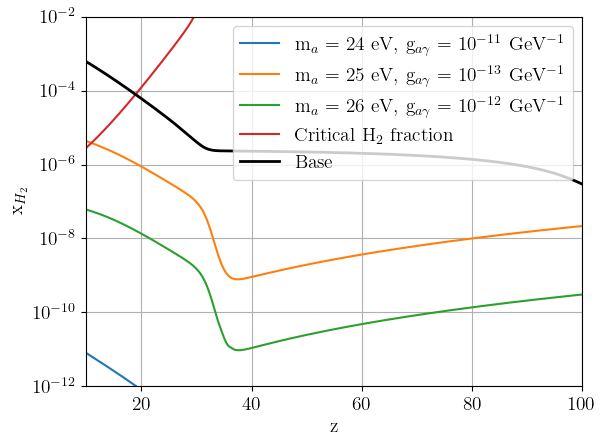

In [496]:
plt.figure()

plt.plot(z_eval, result_test[1,0], label=r'm$_a$ = 24 eV, g$_{a \gamma}$ = 10$^{-11}$ GeV$^{-1}$')
plt.plot(z_eval, result_test[2,2], label=r'm$_a$ = 25 eV, g$_{a \gamma}$ = 10$^{-13}$ GeV$^{-1}$')
plt.plot(z_eval, result_test[3,1], label=r'm$_a$ = 26 eV, g$_{a \gamma}$ = 10$^{-12}$ GeV$^{-1}$')

plt.plot(z_eval, crit_H2(z_eval, 36.3), label = r'Critical H$_2$ fraction' )

plt.plot(solution_base_xH2.t, solution_base_xH2.y[0], label='Base', linewidth=2, color='black')

plt.yscale('log')
plt.xlim(10,100)
plt.ylim(1e-12,1e-2)
plt.grid()
plt.xlabel('z')
plt.ylabel(r'x$_{H_2}$')
plt.legend()
plt.show()

### Complete scan

This part is incomplete right now, and doing a complete scan will be awfully slow. I have not been able to do it yet.

In [104]:
# axion masses 
ma_list = np.linspace(0.76, 13.6, 100)

# couplings
ga_list = 10**np.linspace(-9,-16, 50)

X, Y = np.meshgrid(ma_list, ga_list)

In [105]:
# Create the solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-1)

X, Y =np.meshgrid(ma_list, ga_list)

# Create an empty list to store the results
results = np.empty((len(ma_list), len(ga_list)), dtype=object)


In [106]:
# mark the location of z=10
print(z_list[100])

z10=100

100


In [107]:
%%time

# Loop over the meshgrid of parameters and solve the ODE
for i, ma in enumerate(ma_list): 
    for j, ga in enumerate(ga_list):
        sol = solve_ivp(
            dxH2_dz, z_span, np.array([1e-8]),
            args=(ma, ga),
            t_eval=z_eval,
            method='Radau',
            rtol=1e-4, atol=1e-11
        )
        results[i][j] = sol.y[0]

KeyboardInterrupt: 